
# 0. Pseudo Data Generator 

- Output: (id, timestamp, data vec of 1s (100x3))

# 1. Data Stream (? + Data Preprocessing)

- Input: (id, timestamp, data vec of 1s (100x3))

- Process: Data buffer (Kafka) 

- Output: [(id, timestamp, data vec of 30s (3000x3)), (id, timestamp, data vec of 30s (3000x3)), ... ] for every second

# 2. Phase Picking

- Preload: NN model of PhaseNet

- Input: [(id, timestamp, data vec (3000x3)), (id, timestamp, data vec of (3000x3)), ... ]

- Process: PhaseNet 

<!-- - Output: (id, timestamp, idx_p, prob_p, amp_p, idx_s, prob_s, amp_s) -->
- Output: [(id, timestamp, idx(int), prob(float), amp(float), type(string)), ...]

# 3. Data Stream

<!-- - Input: (id, timestamp, idx_p, prob_p, amp_p, idx_s, prob_s, amp_s) of overlapping 30s -->
- Input: [(id, timestamp, idx, prob, amp, type), ...] of overlapping 30s

- Process: Data buffer (Kafka) 

<!-- - Output: (id, timestamp, idx_p, prob_p, amp_p, idx_s, prob_s, amp_s) with no overlapping and reprot the recent 10 s. -->
- Output: [(id, timestamp, idx, prob, amp, type), ...] with no overlapping and reprot the recent 10 s. 

# 4. Association

- Preload: csv file of seismic station information (id, latitude, longitude, elevation)

<!-- - Input: (id, timestamp, idx_p, prob_p, amp_p, idx_s, prob_s, amp_s) -->
- Input: [(id, timestamp, idx, prob, amp, type), ...]

- Process: GMMA

- Output: [(timestamp, latitude, longtidue, depth, magnitude), ...] of earthquakes

# 5. Data Stream

- Input: [(timestamp, latitude, longtidue, depth, magnitude), ...]

- Process: Data buffer (Kafka) 

- Output: [(timestamp, latitude, longtidue, depth, magnitude), ...]

# 6. Visulization and Notification

- Input: [(timestamp, latitude, longtidue, depth, magnitude), ...] of earthquakes

- WebUI + Twitter Bot

## Code:

## 1. Data

In [33]:
import obspy
import pandas as pd
import os
from datetime import datetime
import numpy as np
import time
import requests
import matplotlib.pyplot as plt

In [34]:
waveform_path = "./data/waveforms"
fnames = pd.read_csv("fname.csv")
stations = pd.read_csv("stations.csv", sep="\t")

In [41]:
normalize = lambda x: (x - np.mean(x))/np.std(x)
calc_dt = lambda t1, t2: (datetime.strptime(t1, "%Y-%m-%dT%H:%M:%S.%f") - datetime.strptime(t2, "%Y-%m-%dT%H:%M:%S.%f")).total_seconds()
def visulize(waveforms, ids, timestamps, picks, sampling_rate):
    plt.figure()
    for i in range(len(waveforms)):
        plt.plot(normalize(waveforms[i][:, 0])/6 + i, "k", linewidth=0.5)
    
    idx_dict = {k: i for i, k in enumerate(ids)}
    for i in range(len(picks)):
        if picks[i]["type"] == "P":
            color = "blue"
        else:
            color = "red"
        idx = int(calc_dt(picks[i]["timestamp"], timestamps[idx_dict[picks[i]["id"]]]) * sampling_rate)
        plt.plot([idx, idx], [idx_dict[picks[i]["id"]]-0.5, idx_dict[picks[i]["id"]]+0.5], color=color)
    plt.show()
        

2020-10-01T00.mseed
CI.BOM..HH 2020-10-01T00:00:00.003 (10000, 3)
CI.COA..HH 2020-10-01T00:00:00.003 (10000, 3)
CI.CRR..HH 2020-10-01T00:00:00.003 (10000, 3)
CI.DRE..HH 2020-10-01T00:00:00.003 (10000, 3)
CI.ERR..HH 2020-10-01T00:00:00.003 (10000, 3)
CI.FRK..HH 2020-10-01T00:00:00.003 (10000, 3)
CI.IMP..HH 2020-10-01T00:00:00.003 (10000, 3)
CI.RXH..HH 2020-10-01T00:00:00.003 (10000, 3)
CI.SAL..HH 2020-10-01T00:00:00.003 (10000, 3)
CI.SGL..HH 2020-10-01T00:00:00.003 (10000, 3)
CI.SLV..HH 2020-10-01T00:00:00.003 (10000, 3)
CI.SNR..HH 2020-10-01T00:00:00.003 (10000, 3)
CI.SWS..HH 2020-10-01T00:00:00.003 (10000, 3)
CI.WES..HH 2020-10-01T00:00:00.003 (10000, 3)
CI.WMD..HH 2020-10-01T00:00:00.003 (10000, 3)
CI.YUH2..HH 2020-10-01T00:00:00.003 (10000, 3)


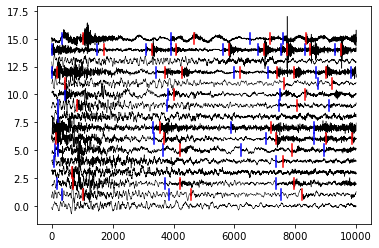

RuntimeError: No active exception to reraise

In [54]:
window_size = 10000
sampling_rate = 100
dtype = "float32"
timestamp = lambda x: x.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]

for i, row in fnames.iterrows():
    print(row.loc["fname"])
    meta = obspy.read(os.path.join(waveform_path, row.loc["fname"]))
    assert(meta[0].stats.sampling_rate == sampling_rate)
    meta = meta.merge(fill_value=0)
    start_time = min([st.stats.starttime for st in meta])
    end_time = max([st.stats.endtime for st in meta])
    meta = meta.trim(start_time, end_time, pad=True, fill_value=0)
    num_station = len(stations)
    nt = len(meta[0].data)
    data = np.zeros([num_station, nt, 3], dtype=dtype)
    station_id = []
    for i in range(num_station):
        sta = stations.iloc[i]["station"]
        station_id.append(sta)
        comp = stations.iloc[i]["component"].split(",")
        resp = stations.iloc[i]["response"].split(",")
        for j in range(len(comp)):
            data[i, :, j] = meta.select(id=sta+comp[j])[0].data.astype(dtype) / float(resp[j])
    idx = 0
    while idx < nt:
        id_lst = []
        timestamp_lst = []
        vec = []
        for i in range(num_station):
            print (station_id[i], timestamp(start_time+idx/sampling_rate), data[i, idx:idx+window_size, :].shape)
            id_lst.append(station_id[i])
            timestamp_lst.append(timestamp(start_time+idx/sampling_rate))
            vec.append(data[i, idx:idx+window_size, :])
        idx += window_size
        time.sleep(1)

        meta = {"id": id_lst, 
                "timestamp": timestamp_lst, 
                "vec": np.array(vec).tolist(),
                "dt": 1.0/sampling_rate}
        resp = requests.get("http://localhost:8000/predict", json=meta)
        # print(resp.json())

        visulize(vec, id_lst, timestamp_lst, resp.json(), sampling_rate)
        if idx >= 1*window_size:
            raise

In [61]:

catalog = requests.get("http://localhost:8000/predict", json=resp.json())


In [62]:
resp.json()

[{'id': 'CI.COA..HH',
  'timestamp': '2020-10-01T00:00:03.203',
  'prob': 0.677594006061554,
  'amp': 4.210290049037987,
  'type': 'P'},
 {'id': 'CI.COA..HH',
  'timestamp': '2020-10-01T00:00:38.653',
  'prob': 0.4602906405925751,
  'amp': 3.7042624217895446,
  'type': 'P'},
 {'id': 'CI.COA..HH',
  'timestamp': '2020-10-01T00:01:15.443',
  'prob': 0.9098023772239685,
  'amp': 3.9786040200442607,
  'type': 'P'},
 {'id': 'CI.COA..HH',
  'timestamp': '2020-10-01T00:00:10.293',
  'prob': 0.5169942378997803,
  'amp': 3.1932637371288344,
  'type': 'S'},
 {'id': 'CI.COA..HH',
  'timestamp': '2020-10-01T00:00:45.583',
  'prob': 0.35775867104530334,
  'amp': 3.613964771469191,
  'type': 'S'},
 {'id': 'CI.COA..HH',
  'timestamp': '2020-10-01T00:01:22.323',
  'prob': 0.4434463083744049,
  'amp': 3.521641181196238,
  'type': 'S'},
 {'id': 'CI.CRR..HH',
  'timestamp': '2020-10-01T00:00:01.563',
  'prob': 0.6647495627403259,
  'amp': 4.2583504905340295,
  'type': 'P'},
 {'id': 'CI.CRR..HH',
  'times